# 05 Evolución de los tópicos dentro de los usuarios con intereses políticos
## Objetivo: ver como evolucionó la utilización de ciertos tópicos por parte de los seguidores de los candidatos y detectar tópicos específicos.

Analizamos como los seguidores de los cuatro candidatos utilizaron tópicos en particular y buscamos si existen tópicos que fueron utilizados particularmente por alguno de los cuatro grupos

# Parámetros de generación de la red de *hashtags*

- USAR_RETWEETS: usar hashtags provenientes de todos los tweets o únicamente aquellos que no fueron retweets
- UMBRAL: cantidad mínima de veces que coocurren dos hashtags en tweets para estar presentes en la búsqueda de topicos
- FILTRAR_ENTROPIA: aplicar filtro de entropía de aquellos hashtags que fueron usados por los cuatro grupos de seguidores de políticos mas uniformemente

In [1]:
import pandas as pd
import numpy as np
import datetime

%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
USAR_RETWEETS = False
UMBRAL = 3
FILTRAR_ENTROPIA = True

MAX_FACTOR_TOPICO = 128
UMBRAL_TOPICOS = 3

In [3]:
macri_color = "#FFD700"
scioli_color = "#75AADB"
massa_color = "#3C3C3C"
stolbizer_color = "#EE4D8B"

paso_date = datetime.datetime(2015, 8, 9)
first_round_date = datetime.datetime(2015, 10, 25)
second_round_date = datetime.datetime(2015, 11, 22)
x_ticks = [datetime.datetime(2015,8,1), datetime.datetime(2015,9,1), datetime.datetime(2015,10,1), datetime.datetime(2015,11,1),
   datetime.datetime(2015,12,1), datetime.datetime(2016,1,1), datetime.datetime(2016,2,1), datetime.datetime(2016,3,1)]
x_labels = ["Ago/15","Sep/15", "Oct/15","Nov/15", "Dic/15", "Ene/16", "Feb/16", "Mar/16"]

In [4]:
hashtags = pd.read_csv('csv_files/hashtags.csv')

In [5]:
user_hashtags = pd.read_csv('csv_files/user_hashtags.csv')

In [6]:
def extract_oslom():
    if (USAR_RETWEETS):
        return pd.read_csv('csv_files/hashtags_comunidades_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'.csv')
    else:
        return pd.read_csv('csv_files/hashtags_comunidades_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'_sin_retweets.csv')

def get_user_hashtag_topic():
    df = extract_oslom()
    grouped = df.groupby("cluster").count().reset_index()[["cluster", "id"]]
    grouped.columns = ["cluster", "topic_count"]
    grouped = grouped[grouped.topic_count >= UMBRAL_TOPICOS]
    df = df.merge(grouped)
    df = df.merge(hashtags)
    df = df.merge(user_hashtags)
    return df

In [7]:
if (USAR_RETWEETS):
    usuario_topico_df = get_user_hashtag_topic()
else:
    usuario_topico_df = get_user_hashtag_topic()
usuario_topico_df.head()

,id,cluster,topic_count,hashtag,user_id,timestamp
0,10,673,38,Gol,186068,2015-10-15 01:42:09
1,10,673,38,Gol,77779,2015-09-26 14:06:21
2,10,673,38,Gol,77779,2015-09-26 14:03:52
3,10,673,38,Gol,257681,2015-09-19 19:23:18
4,10,673,38,Gol,294214,2015-08-12 03:29:42


In [8]:
gr = usuario_topico_df.groupby("cluster").count().reset_index().sort_values("id", ascending=False)
max_topics = gr[["id"]].iloc[0]["id"]
max_topics

1235517

In [9]:
remaining_topics = gr[gr["id"] >= (max_topics/MAX_FACTOR_TOPICO)][["cluster"]]
remaining_topics.shape

(124, 1)

In [10]:
usuario_topico_df = usuario_topico_df.merge(remaining_topics)
usuario_topico_df.shape

(6265905, 6)

In [11]:
usuario_topico_df.head()

,id,cluster,topic_count,hashtag,user_id,timestamp
0,14,1236,100,LaBarraTheWalkingDead,186068,2015-10-13 02:29:36
1,14,1236,100,LaBarraTheWalkingDead,118961,2015-11-03 02:11:44
2,14,1236,100,LaBarraTheWalkingDead,205142,2015-10-20 00:53:54
3,14,1236,100,LaBarraTheWalkingDead,205142,2015-10-13 13:32:41
4,14,1236,100,LaBarraTheWalkingDead,205424,2015-10-13 00:51:17


In [12]:
follower_network = pd.read_csv('csv_files/followers.csv')

In [13]:
n = len(follower_network.follower_id.drop_duplicates())
n

295605

In [14]:
def extract_only_followers(df, politician_id, except_politicians):
    """Extrae de la red de usuarios, aquellos usuarios que siguen a :param politician_id: y que NO siguen a ninguno de 
    los usuarios que estan dentro de :param except_politicians: """
    politician_followers = df[df["followed_id"] == politician_id].groupby("follower_id").count().reset_index().follower_id.values
    other_fols = df[df["followed_id"].isin(except_politicians)].follower_id.values
    filtered = [only for only in politician_followers if only not in other_fols]
    return filtered

In [15]:
users = pd.read_csv('csv_files/users.csv')
users.shape

(308169, 2)

In [16]:
macri_id = 137027
scioli_id = 188326
massa_id = 12218
stolbizer_id = 224325

In [17]:
macri_followers = extract_only_followers(follower_network, macri_id, [scioli_id, massa_id, stolbizer_id])
scioli_followers = extract_only_followers(follower_network, scioli_id, [macri_id, massa_id, stolbizer_id])
massa_followers = extract_only_followers(follower_network, massa_id, [macri_id, scioli_id, stolbizer_id])
stolbizer_followers = extract_only_followers(follower_network, stolbizer_id, [macri_id, scioli_id, massa_id])

In [18]:
macri_df = pd.DataFrame(data=[i for i in zip(macri_followers, np.repeat(0, len(macri_followers)))], columns=["user_id", "user_cluster"])
scioli_df = pd.DataFrame(data=[i for i in zip(scioli_followers, np.repeat(1, len(scioli_followers)))], columns=["user_id", "user_cluster"])
massa_df = pd.DataFrame(data=[i for i in zip(massa_followers, np.repeat(2, len(massa_followers)))], columns=["user_id", "user_cluster"])
stolbizer_df = pd.DataFrame(data=[i for i in zip(stolbizer_followers, np.repeat(3, len(stolbizer_followers)))], columns=["user_id", "user_cluster"])
user_communities_df = pd.concat((macri_df,scioli_df,massa_df,stolbizer_df))
user_communities_df.head(2)

,user_id,user_cluster
0,8,0
1,9,0


In [19]:
merged = usuario_topico_df.merge(user_communities_df)
merged.shape

(2009791, 7)

In [20]:
merged.head(2)

,id,cluster,topic_count,hashtag,user_id,timestamp,user_cluster
0,14,1236,100,LaBarraTheWalkingDead,287497,2015-10-13 01:05:41,0
1,70892,1236,100,TWD5enFOX,287497,2015-02-10 01:14:01,0


In [21]:
def get_qk():
    clusters_size = user_communities_df.groupby("user_cluster").count().reset_index()
    clus_size_total = sum(clusters_size.user_id.values)
    clusters_size.user_id = clusters_size.user_id / clus_size_total
    qk = clusters_size.sort_values("user_cluster").user_id.values
    return qk
get_qk()

array([0.44561972, 0.37420115, 0.10599664, 0.07418249])

In [22]:
topics = merged[["cluster"]].drop_duplicates().sort_values("cluster")
topics.shape

(124, 1)

In [23]:
import itertools
import scipy.stats
cluster = 4
def get_user_cluster_topic_combination():
    """Devuelve todas las combinaciones posibles entre comunidades y topicos"""
    list1= range(cluster)
    list2= topics.cluster.values
    d = []
    for i in list1:
        for j in list2:
            d.append([i,j,0])
    todos = pd.DataFrame(data=d)
    todos.columns=["user_cluster", "cluster", "usos"]
    return todos

def agg_entropy(pk):
    """Funcion auxiliar de agregacion de los DataFrames"""
    qk = get_qk()
    return scipy.stats.entropy(pk, qk)

def get_entropy():
    """Calculo de la divergencia de Kullback-Leibler para cada distribucion de usos de un topico,
    respecto a las comunidades de usuarios"""
    c = merged.groupby(["cluster","user_cluster"]).count().reset_index()
    todos = get_user_cluster_topic_combination()
    todos_set = set ([((i,j)) for i,j in zip(todos.user_cluster.values, todos.cluster.values)])
    c_merged = c.merge(todos, how='left')
    existing_s = set ([((i,j)) for i,j in zip(c_merged.user_cluster.values, c_merged.cluster.values)])
    diff = todos_set.difference(existing_s)    
    missing = pd.DataFrame(data=[(i,j,0) for i,j in diff], columns=["user_cluster", "cluster", "user_id"])
    filled = pd.concat((c,missing))
    filled["user_id"] = pd.to_numeric(filled["user_id"], downcast='float')
    g = filled.groupby("cluster").sum().reset_index()[["cluster", "user_id"]]
    g.columns = [["cluster", "total"]]
    t = filled.merge(g)
    t.sort_values(["cluster", "user_cluster"], inplace=True)
    t["proba"] = t.user_id / t.total
    ans_pk = t.groupby("cluster").agg({'proba': scipy.stats.entropy}).reset_index()
    ans_pk_qk = t.groupby("cluster").agg({'proba': agg_entropy}).reset_index()
    ans_pk_qk.columns=["cluster", "proba_kull_lei"]
    ans = ans_pk.merge(ans_pk_qk)
    return ans

In [24]:
ans = get_entropy()
ans.head()

,cluster,proba,proba_kull_lei
0,536,0.583944,0.382498
1,677,0.819775,0.208520
2,699,1.020009,1.009582
3,770,1.247203,0.249295
4,889,0.386924,0.621316


In [25]:
min_df = usuario_topico_df[["cluster", "hashtag", "user_id", "timestamp"]].groupby(["cluster", "hashtag", "user_id"]).min().reset_index()
min_df["datetime"] = pd.to_datetime(min_df['timestamp']).apply(lambda x: x.date())
min_df.head()

,cluster,hashtag,user_id,timestamp,datetime
0,536,AbajoCADENAS,5448,2016-03-09 23:08:23,2016-03-09
1,536,AbajoCADENAS,7665,2016-03-10 08:41:28,2016-03-10
2,536,AbajoCADENAS,11843,2016-03-10 01:19:17,2016-03-10
3,536,AbajoCADENAS,17943,2016-03-09 23:40:32,2016-03-09
4,536,AbajoCADENAS,18318,2016-03-10 05:44:18,2016-03-10


In [26]:
max_topics_communities = ans.sort_values("proba_kull_lei").tail(10)["cluster"].values
max_topics_communities

array([1343, 1130,  996, 1256, 1253, 1247,  889,  699, 1142, 1324])

### Tópicos más utilizados

In [27]:
max_topics = usuario_topico_df.groupby("cluster").count().reset_index()[["cluster", "topic_count"]].sort_values("topic_count", ascending=False)
max_topics = max_topics.head(10)["cluster"].values
max_topics

array([1402, 1253, 1382, 1378, 1231, 1384, 1368, 1362, 1038, 1381])

In [28]:
# Topicos en comun
[x for x in max_topics_communities if x in max_topics]

[1253]

In [29]:
usuario_topico_df["datetime"] = pd.to_datetime(usuario_topico_df['timestamp']).apply(lambda x: x.date())

In [30]:
def get_timeseries(cluster_id, disaggregate = True):
    """Filtrar para un topico el uso acumulado por parte de los usuarios en el periodo bajo analisis"""
    d_from = datetime.date(2015,7,15)
    d_to = datetime.date(2016,3,31)
    pol_folls_array = [macri_followers, scioli_followers, massa_followers, stolbizer_followers]
    df = usuario_topico_df
    g = df[(df["cluster"] == cluster_id) & (df["datetime"] >= d_from) & (df["datetime"] <= d_to)]\
        .groupby("datetime").count().reset_index()[["datetime", "cluster"]]
    #g["cluster"] = g["cluster"] / float(len(macri_followers) + len(scioli_followers) + len(massa_followers) + len(stolbizer_followers))
    if (not disaggregate):
        return pd.Series(g["cluster"].values, g["datetime"])
    comm_ts = [pd.Series(g["cluster"].values, g["datetime"])]
    for i in pol_folls_array:
        t = df[(df["cluster"] == cluster_id) & (df["datetime"] >= d_from) & (df["datetime"] <= d_to) & (df["user_id"].isin(i))]\
        .groupby("datetime").count().reset_index()[["datetime", "cluster"]]
        comm_ts.append(pd.Series(t["cluster"].values, t["datetime"]))
    return comm_ts

In [31]:
def get_min_timeseries(cluster_id, disaggregate = True):
    """Filtrar para un topico el PRIMER uso de un topico por parte de los usuarios
    y acumular, en el periodo bajo analisis"""
    d_from = datetime.date(2015,7,15)
    d_to = datetime.date(2016,3,31)
    pol_folls_array = [macri_followers, scioli_followers, massa_followers, stolbizer_followers]
    g = min_df[(min_df["cluster"] == cluster_id) & (min_df["datetime"] >= d_from) & (min_df["datetime"] <= d_to)]\
        .groupby("datetime").count().reset_index()[["datetime", "cluster"]]
    #g["cluster"] = g["cluster"] / float(len(macri_followers) + len(scioli_followers) + len(massa_followers) + len(stolbizer_followers))
    if (not disaggregate):
        return pd.Series(g["cluster"].values, g["datetime"])
    comm_ts = [pd.Series(g["cluster"].values, g["datetime"])]
    for i in pol_folls_array:
        t = min_df[(min_df["cluster"] == cluster_id) & (min_df["datetime"] >= d_from) & (min_df["datetime"] <= d_to) & (min_df["user_id"].isin(i))]\
        .groupby("datetime").count().reset_index()[["datetime", "cluster"]]
        comm_ts.append(pd.Series(t["cluster"].values, t["datetime"]))
    return comm_ts

In [32]:
comm_size = user_communities_df.groupby("user_cluster").count().reset_index()

In [33]:
comm_size[comm_size["user_cluster"] == 0]["user_id"].values[0]

38211

In [34]:
def show_min_top_hashtags(cluster_id, n=10):
    return min_df[min_df["cluster"] == cluster_id][["hashtag", "user_id"]].groupby("hashtag").count().reset_index().sort_values("user_id", ascending=False).head(n)

In [35]:
plt.rcParams.update({'font.size' : 30})
plt.rcParams['figure.figsize'] = [20, 15]
def show_min_topic(topic):
    """Funcion para graficar el uso acumulado de un :param topico: en particular respecto a las cuatro comunidades
    de usuarios"""
    plt.axvline(paso_date, color="Black",linestyle='dashed')
    plt.axvline(first_round_date, color="Black",linestyle='dashed')
    plt.axvline(second_round_date, color="Black",linestyle='dashed')
    time_series = get_min_timeseries(topic)

    (time_series[1].cumsum()/comm_size[comm_size["user_cluster"] == 0]["user_id"].values[0]).plot(label="Macri", color=macri_color, linewidth=4)
    (time_series[2].cumsum()/comm_size[comm_size["user_cluster"] == 1]["user_id"].values[0]).plot(label="Scioli", color=scioli_color, linewidth=4)
    (time_series[3].cumsum()/comm_size[comm_size["user_cluster"] == 2]["user_id"].values[0]).plot(label="Massa", color=massa_color, linewidth=4)
    (time_series[4].cumsum()/comm_size[comm_size["user_cluster"] == 3]["user_id"].values[0]).plot(label="Stolbizer", color=stolbizer_color, linewidth=4)

    print_hashtags = list(map(lambda x: "#" + x ,list(show_min_top_hashtags(topic,2).hashtag.values)))
    print_hashtags.append("...")
    plt.title(u'Tópico ' + str(topic) + "(" + ", ".join(print_hashtags) + ")")
    plt.xlabel('Tiempo')
    plt.ylabel('Activaciones acumuladas de hashtags por usuario')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.xticks(x_ticks, x_labels)
    plt.show()

In [36]:
max_topics

array([1402, 1253, 1382, 1378, 1231, 1384, 1368, 1362, 1038, 1381])

In [37]:
max_topics_communities

array([1343, 1130,  996, 1256, 1253, 1247,  889,  699, 1142, 1324])

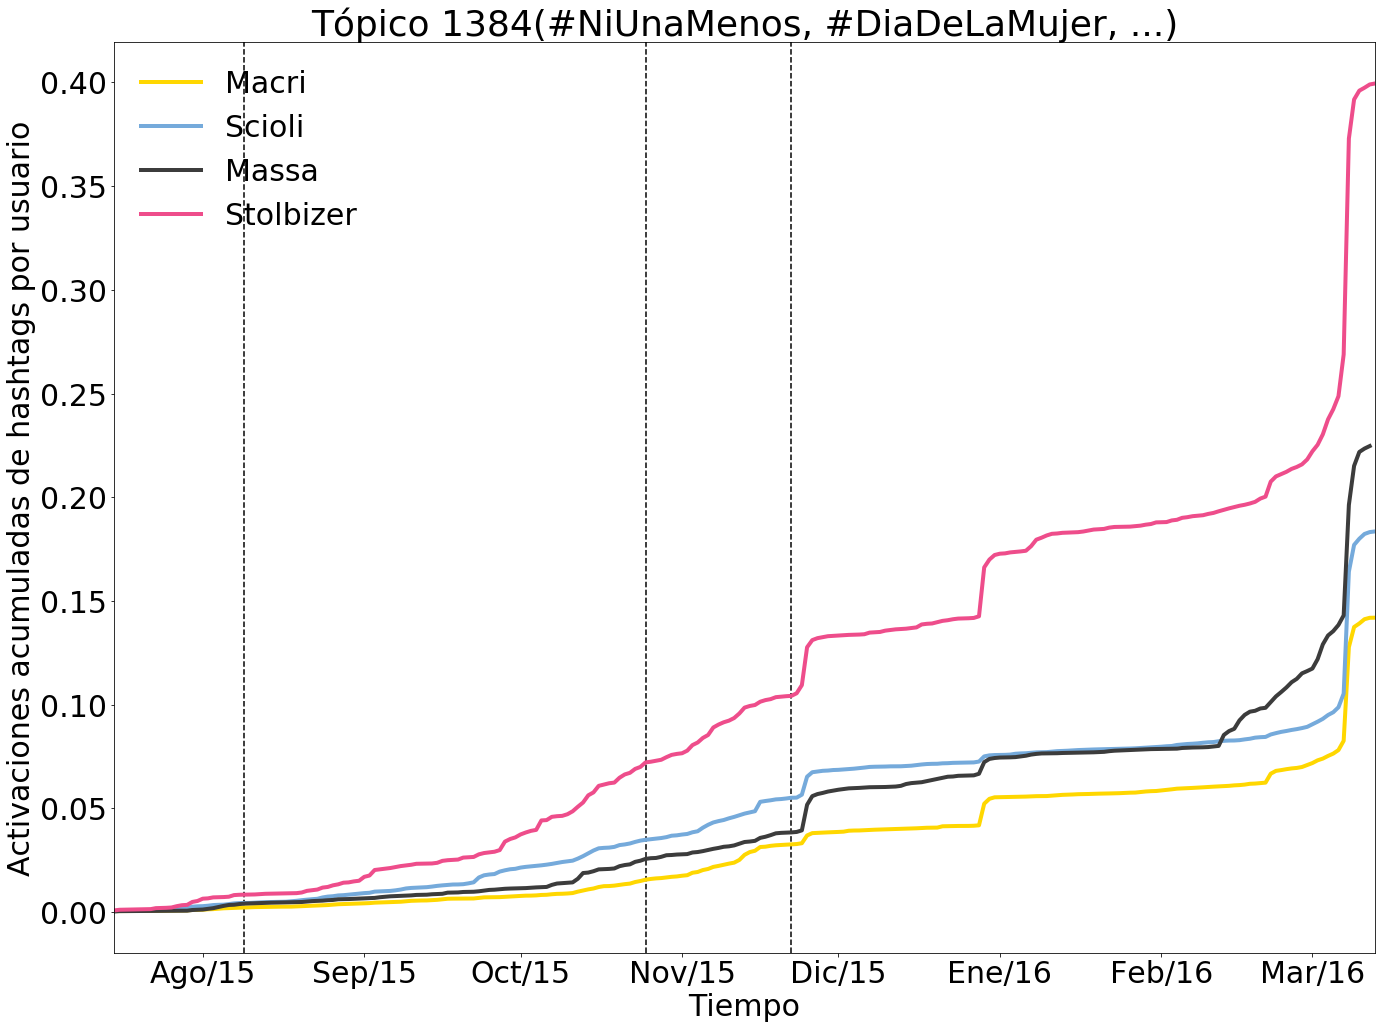

In [38]:
ni_una_menos_topic = usuario_topico_df[usuario_topico_df["hashtag"]=="NiUnaMenos"].cluster.values[0]
show_min_topic(ni_una_menos_topic)

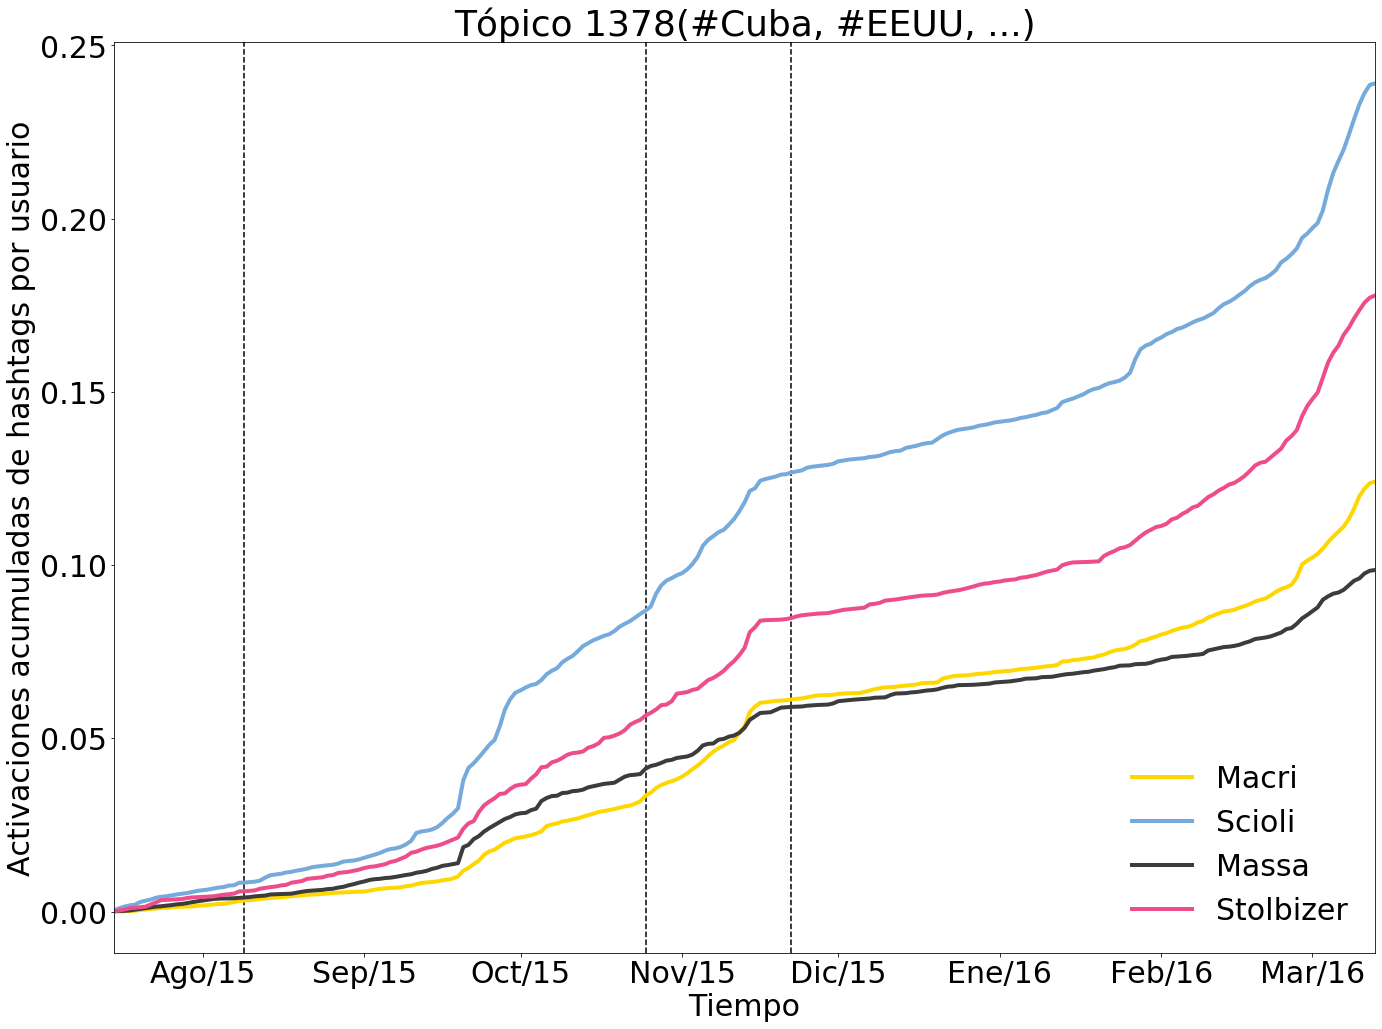

In [39]:
cuba_topic = usuario_topico_df[usuario_topico_df["hashtag"]=="Cuba"].cluster.values[0]
show_min_topic(cuba_topic)

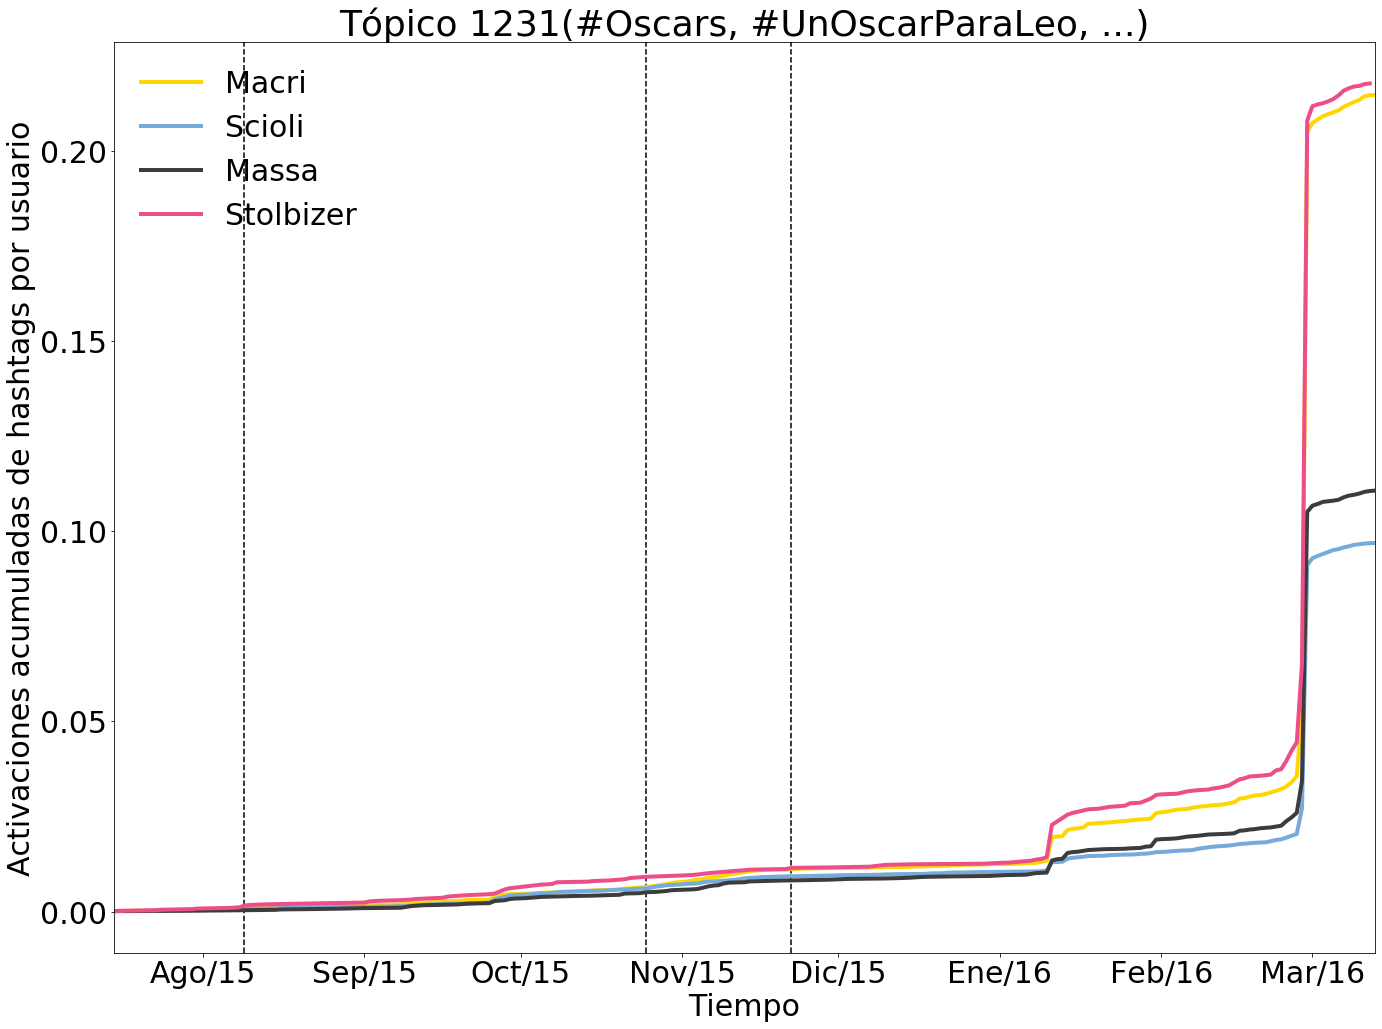

In [40]:
oscars_topic = usuario_topico_df[usuario_topico_df["hashtag"]=="Oscars"].cluster.values[0]
show_min_topic(oscars_topic)

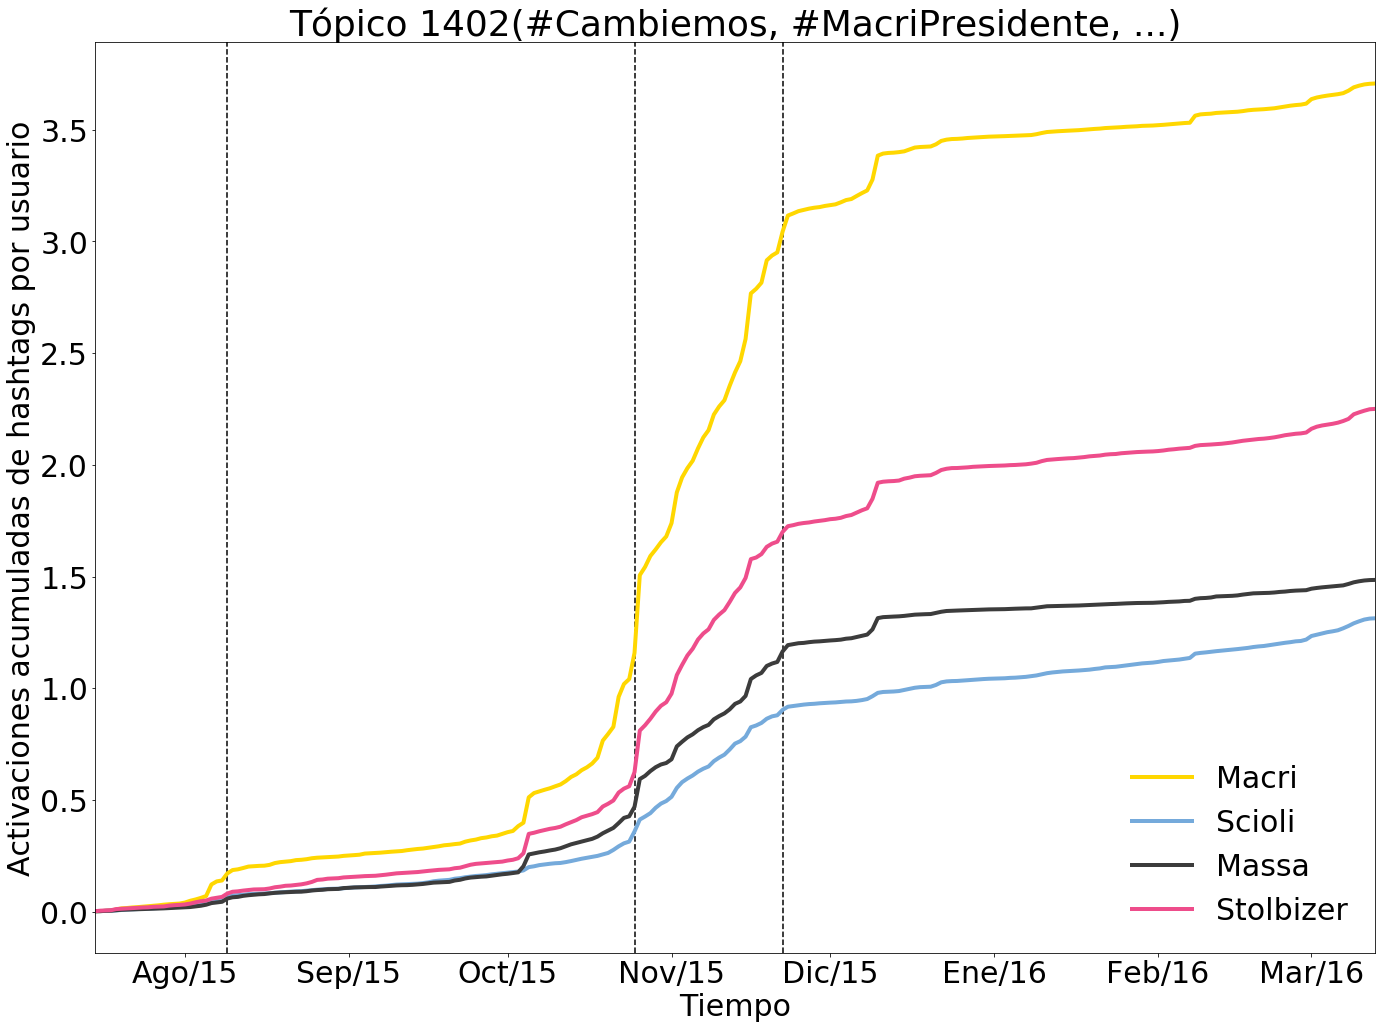

In [41]:
macri_topic = usuario_topico_df[usuario_topico_df["hashtag"]=="MacriPresidente"].cluster.values[0]
show_min_topic(macri_topic)

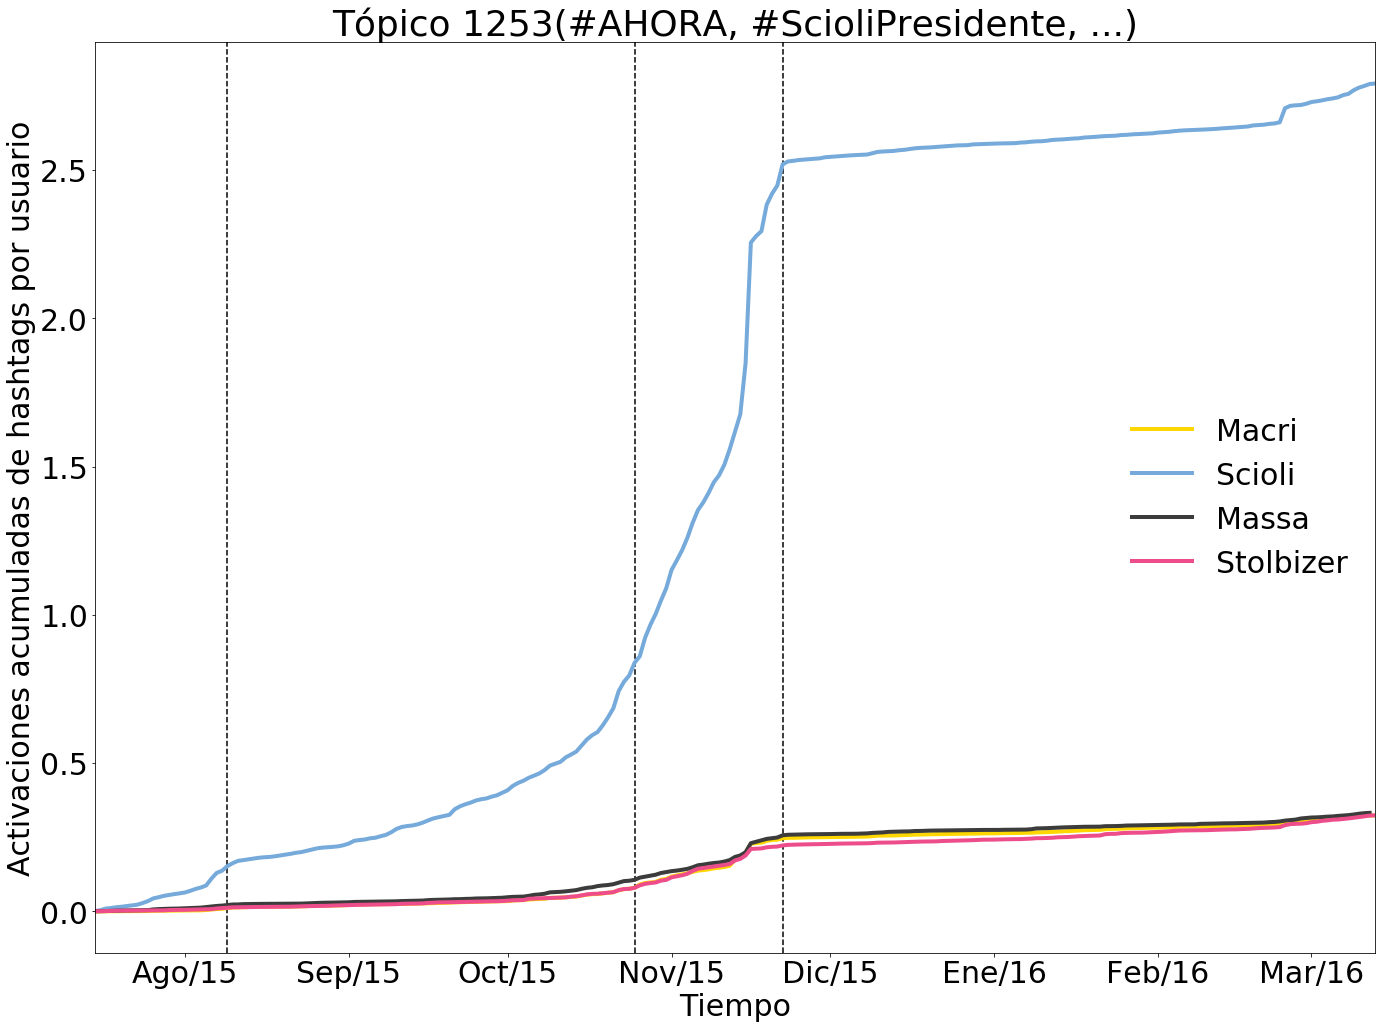

In [42]:
scioli_topic = usuario_topico_df[usuario_topico_df["hashtag"]=="ScioliPresidente"].cluster.values[0]
show_min_topic(scioli_topic)

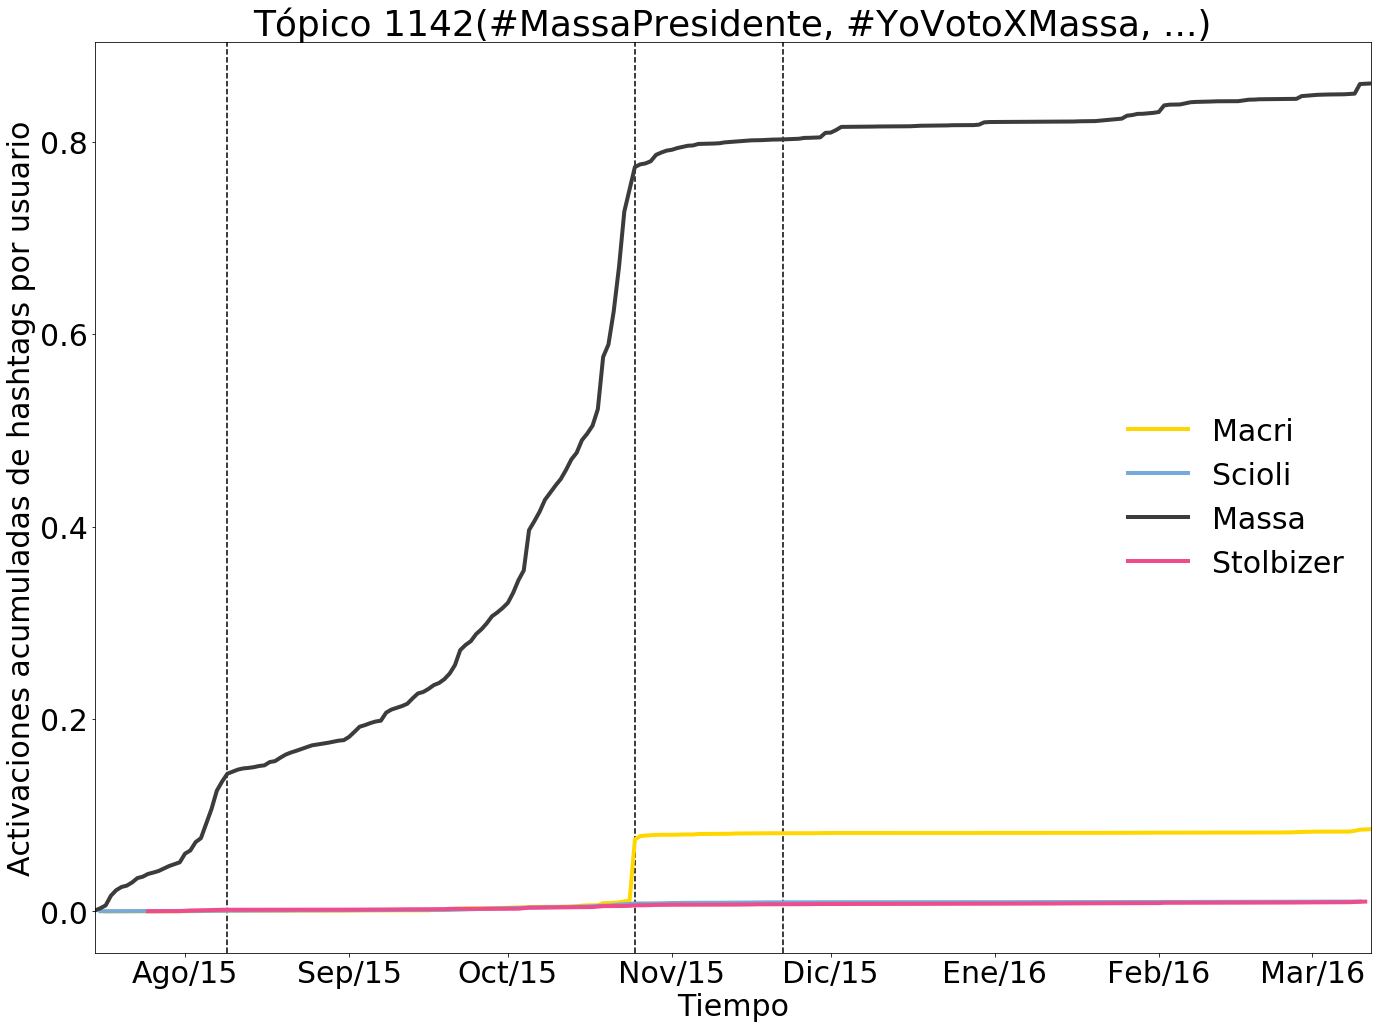

In [43]:
massa_topic = usuario_topico_df[usuario_topico_df["hashtag"]=="MassaPresidente"].cluster.values[0]
show_min_topic(massa_topic)

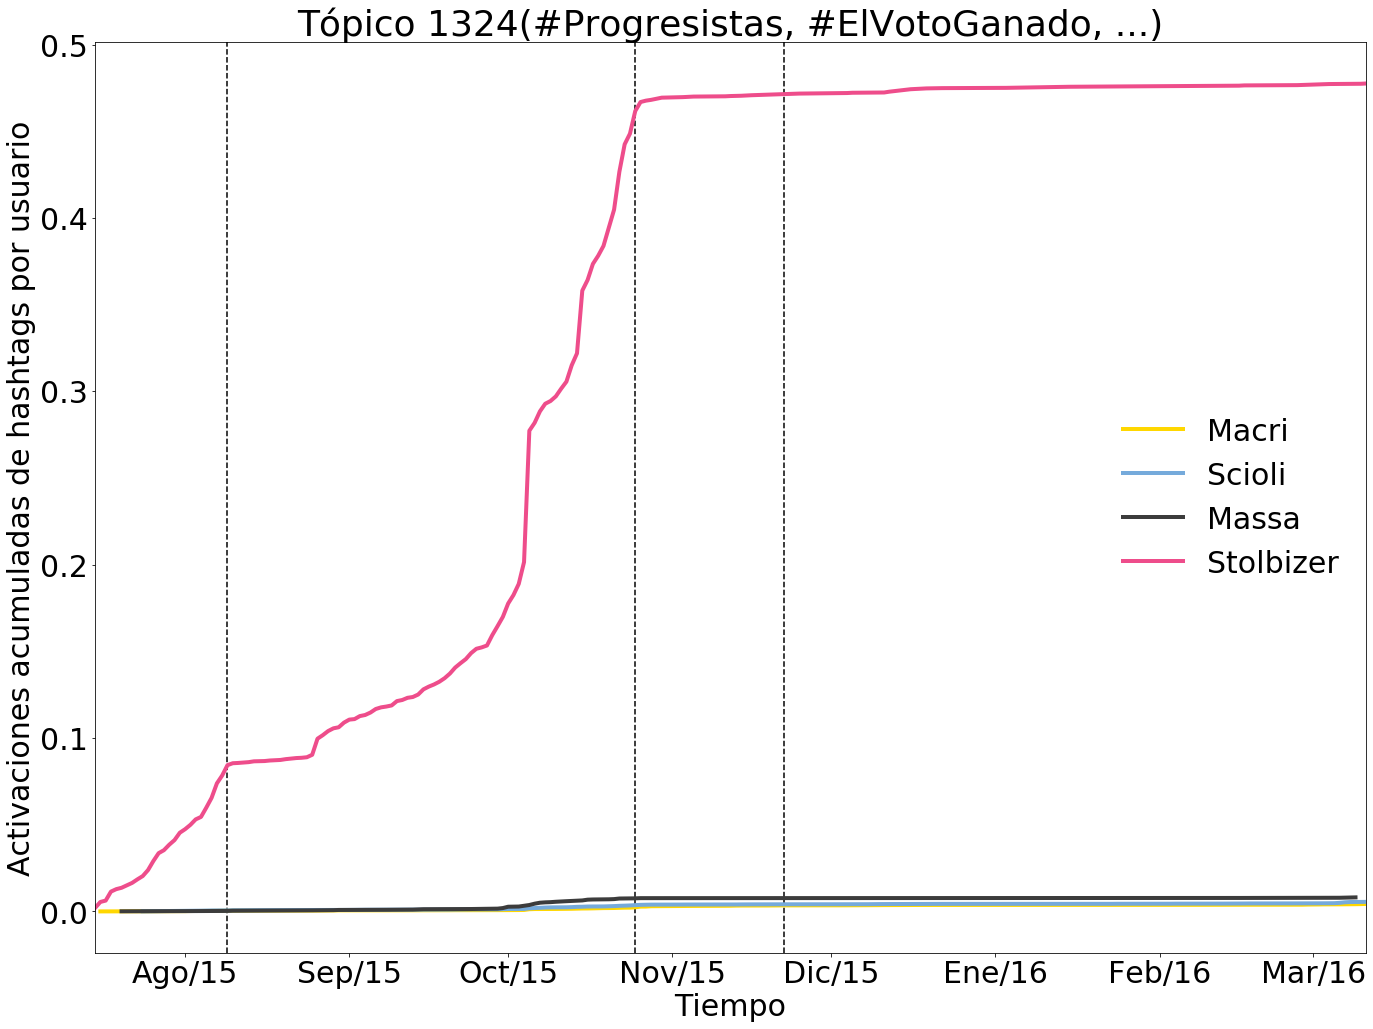

In [44]:
stolbizer_topic = usuario_topico_df[usuario_topico_df["hashtag"]=="StolbizerPresidente"].cluster.values[0]
show_min_topic(stolbizer_topic)

# Grafico para evoluciones acumuladas de cada topico: 10 especificos + 10 mas usados

In [45]:
clusters_size = user_communities_df.groupby("user_cluster").count().reset_index()
clusters_size.columns=["user_cluster", "size"]
def get_main_community_topic_usage(topic):
    topic_usage = merged[merged["cluster"] == topic].groupby("user_cluster").count().reset_index()
    usage = topic_usage.merge(clusters_size)
    usage["ratio"] = usage["id"] / usage["size"]
    return usage.sort_values("ratio", ascending=False).head(1)[["user_cluster"]].values[0][0]

In [46]:
def graficar(topics):
    plt.axvline(paso_date, color="Black",linestyle='dashed')
    plt.axvline(first_round_date, color="Black",linestyle='dashed')
    plt.axvline(second_round_date, color="Black",linestyle='dashed')
    pol_colors = [macri_color, scioli_color, massa_color, stolbizer_color]
    for topic in topics:
        s = get_min_timeseries(topic, False)
        main_community = get_main_community_topic_usage(topic)
        print_hashtags = list(map(lambda x: "#" + x ,list(show_min_top_hashtags(topic,1).hashtag.values)))
        (s.cumsum()/s.sum()).plot(label=str(topic) + "(" + ", ".join(print_hashtags) + ")", 
                                  color=pol_colors[main_community])
    plt.xlabel("Tiempo")
    plt.ylabel("Porcentaje del uso acumulado del tópico")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.xticks(x_ticks, x_labels)

Para estos graficos tengo que pintar de acuerdo al color del grupo de personas que mas uso el topico. Hay que buscar el ratio pk/qk de Kullback-Leibler que de mas alto y utilizar ese color

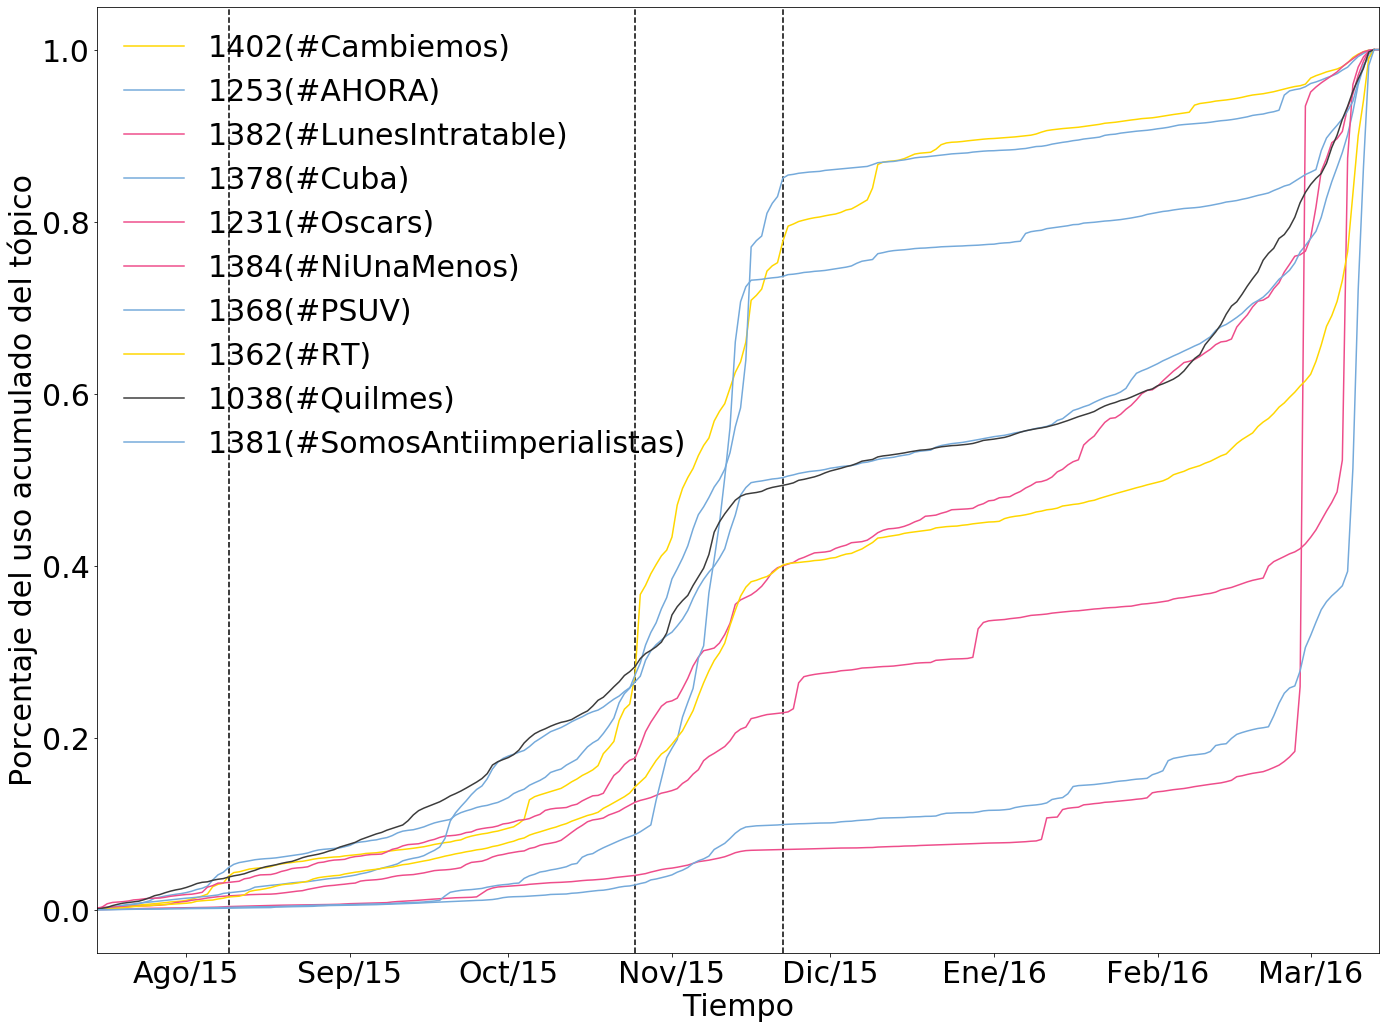

In [47]:
graficar(max_topics)

### 10 tópicos más específicos de cada comunidad

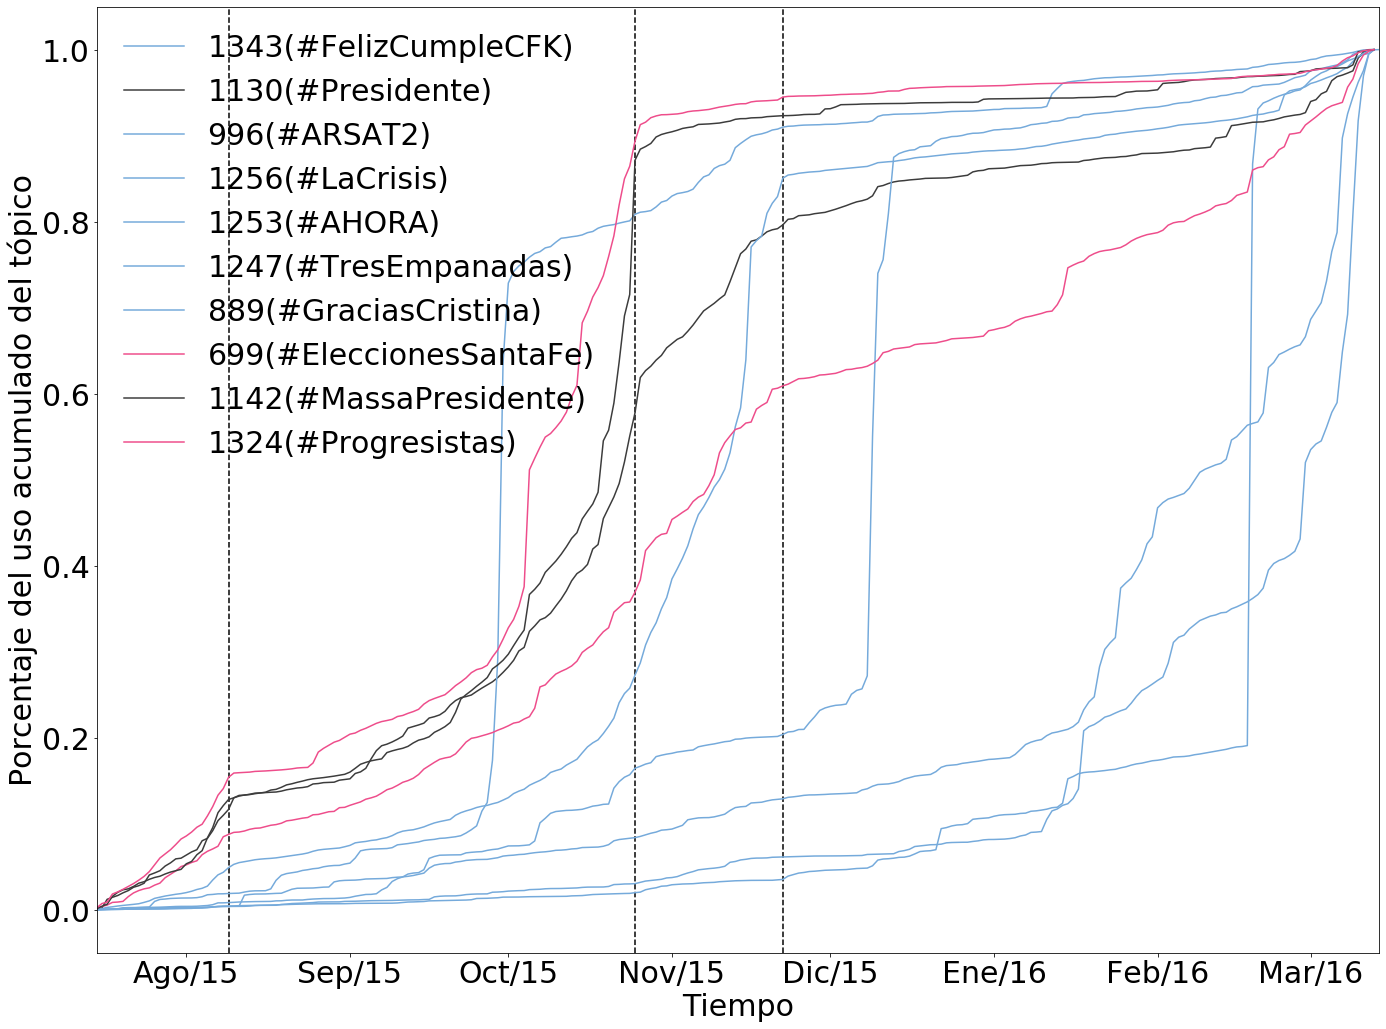

In [48]:
graficar(max_topics_communities)